# # Grossman-Miller Market Making Model Simulation

# This Jupyter Notebook simulates the Grossman-Miller market making model,
# incorporating key features such as Bayesian updating of beliefs, inventory
# management, and risk aversion.

# ## Model Parameters

# These parameters define the characteristics of the market and the market maker.
# They can be adjusted to explore different market conditions.


In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import norm
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'scipy'

In [4]:
num_trades = 2000  # Total number of trades to simulate
initial_price = 100  # Initial price of the asset
initial_spread = 0.5  # Initial bid-ask spread
informed_trader_ratio = 0.2  # Proportion of traders who are informed
info_shock_probability = 0.05  # Probability of an information shock occurring
info_shock_mean = 0.5  # Average size of information shocks
info_shock_std = 0.25  # Standard deviation of information shocks
inventory_limit = 100  # Maximum inventory the market maker can hold
risk_aversion = 0.01  # Market maker's risk aversion (higher = more averse)

# ## Trader Types

# We define constants to represent the two types of traders in the market.


In [5]:
TRADER_TYPE_NOISE = 0  # Noise traders trade randomly
TRADER_TYPE_INFORMED = 1  # Informed traders trade based on private information

# ## Data Initialization

# We initialize a Pandas DataFrame to store the simulation data, including
# trader types, trade sizes, prices, and market maker information.

In [6]:

trades = pd.DataFrame(index=range(num_trades))
trades['trader_type'] = np.random.choice(
    [TRADER_TYPE_NOISE, TRADER_TYPE_INFORMED],
    num_trades,
    p=[1 - informed_trader_ratio, informed_trader_ratio],
)
trades['trade_size'] = np.random.randint(1, 10, num_trades)
trades['mid_price'] = initial_price
trades['bid'] = initial_price - initial_spread / 2
trades['ask'] = initial_price + initial_spread / 2
trades['inventory'] = 0  # Market maker's inventory
trades['probability_informed'] = informed_trader_ratio  # Market maker's belief

# ## Simulate Information Shocks

# We simulate random information shocks that affect the asset's mid-price.
# These shocks represent new information entering the market

In [ ]:
information_shocks = np.random.normal(
    loc=info_shock_mean, scale=info_shock_std, size=num_trades
)
information_events = np.random.choice(
    [0, 1], num_trades, p=[1 - info_shock_probability, info_shock_probability]
)
trades['information'] = information_events * information_shocks

# ## Bayesian Update Function

# This function updates the market maker's belief about the probability of
# trading with an informed trader using a simplified Bayesian update rule.

In [7]:
def bayesian_update(prev_prob, trade_type):
    if trade_type == TRADER_TYPE_INFORMED:
        return min(1.0, prev_prob + 0.1)  # Increase probability
    else:
        return max(0.0, prev_prob - 0.05)  # Decrease probability

# ## Market Maker Quote Function

# This function determines the market maker's bid and ask quotes based on
# the mid-price, inventory, belief about informed traders, and risk aversion.

In [10]:
def market_maker_quotes(
    mid_price, inventory, prob_informed, risk_aversion, base_spread
):
    # Adjust spread based on probability of informed trader
    spread = base_spread * (1 + prob_informed * 2)  # Widen spread if high prob

    # Adjust quotes based on inventory
    inventory_adjustment = risk_aversion * inventory
    bid = mid_price - spread / 2 - inventory_adjustment
    ask = mid_price + spread / 2 - inventory_adjustment
    return bid, ask


# ## Simulate Trading

# This is the main simulation loop, where trades occur, and the market maker
# updates their quotes and beliefs.

In [11]:
for i in range(num_trades):
    # Update mid-price to reflect information
    trades.loc[i, 'mid_price'] = trades.loc[:i]['information'].sum() + initial_price

    # Trader decides to buy or sell
    if random.random() < 0.5:  # 50% chance of buy
        trades.loc[i, 'trade_side'] = 'buy'
        trades.loc[i, 'trade_price'] = trades.loc[i, 'ask']
        trades.loc[i, 'inventory'] -= trades.loc[i, 'trade_size']  # Update inventory
    else:  # Sell
        trades.loc[i, 'trade_side'] = 'sell'
        trades.loc[i, 'trade_price'] = trades.loc[i, 'bid']
        trades.loc[i, 'inventory'] += trades.loc[i, 'trade_size']  # Update inventory

    # Keep inventory within limits
    trades.loc[i, 'inventory'] = max(
        -inventory_limit, min(trades.loc[i, 'inventory'], inventory_limit)
    )

    # Bayesian update of probability of informed trader
    trades.loc[i, 'probability_informed'] = bayesian_update(
        trades.loc[i - 1, 'probability_informed']
        if i > 0
        else informed_trader_ratio,  # Use initial probability for the first trade
        trades.loc[i, 'trader_type'],
    )

    # Market maker sets quotes
    bid, ask = market_maker_quotes(
        trades.loc[i, 'mid_price'],
        trades.loc[i, 'inventory'],
        trades.loc[i, 'probability_informed'],
        risk_aversion,
        initial_spread,
    )
    trades.loc[i, 'bid'] = bid
    trades.loc[i, 'ask'] = ask


/tmp/ipykernel_106207/3564465650.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.12003795794695' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades.loc[i, 'mid_price'] = trades.loc[:i]['information'].sum() + initial_price


# ## Analyze Results

# We print the first few trades to get a quick overview and then generate
# visualizations to analyze the simulation results.


In [12]:
print(trades.head(20))  # Print the first 20 trades

    trader_type  trade_size  mid_price     bid      ask  inventory  \
0             1           2      100.0  99.640  100.440         -4   
1             0           9      100.0  99.715  100.465         -9   
2             0           6      100.0  99.710  100.410         -6   
3             0           5      100.0  99.625  100.275          5   
4             0           8      100.0  99.780  100.380         -8   
5             1           4      100.0  99.690  100.390         -4   
6             0           8      100.0  99.755  100.405         -8   
7             1           5      100.0  99.575  100.325          5   
8             0           6      100.0  99.710  100.410         -6   
9             0           7      100.0  99.605  100.255          7   
10            0           1      100.0  99.690  100.290          1   
11            0           1      100.0  99.735  100.285         -1   
12            0           8      100.0  99.670  100.170          8   
13            1     

# ### Price Dynamics

# This plot shows the evolution of the mid-price, bid price, and ask price
# over the simulation period.

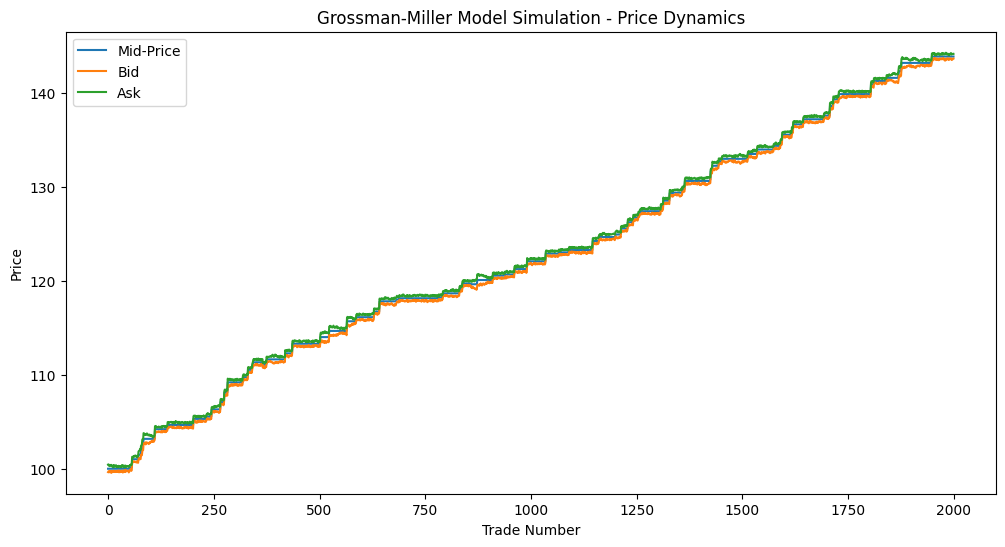

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(trades['mid_price'], label='Mid-Price')
plt.plot(trades['bid'], label='Bid')
plt.plot(trades['ask'], label='Ask')
plt.legend()
plt.title('Grossman-Miller Model Simulation - Price Dynamics')
plt.xlabel('Trade Number')
plt.ylabel('Price')
plt.show()

# ### Market Maker Inventory

# This plot shows the market maker's inventory position over time.
# Fluctuations in inventory reflect the market maker's exposure to the asset.

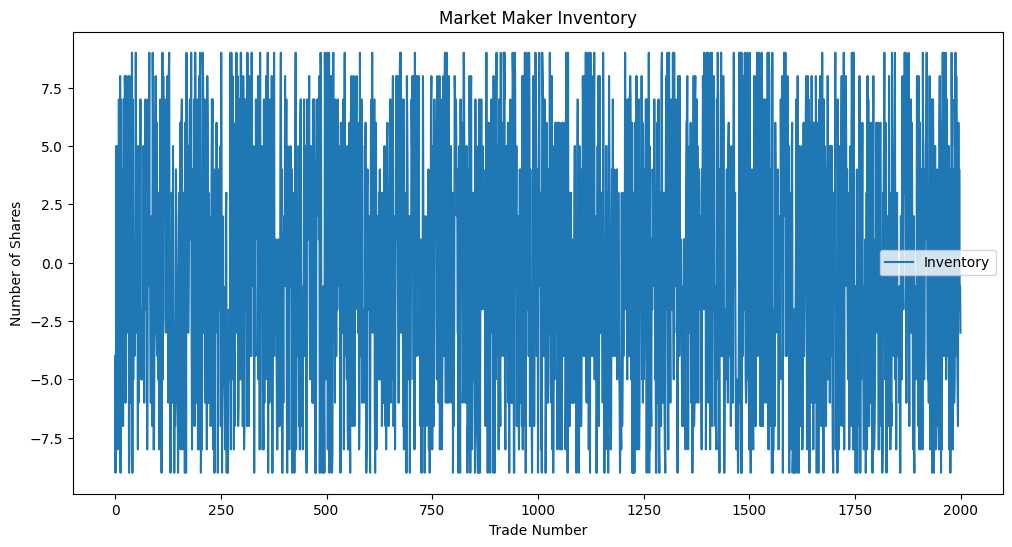

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(trades['inventory'], label='Inventory')
plt.legend()
plt.title('Market Maker Inventory')
plt.xlabel('Trade Number')
plt.ylabel('Number of Shares')
plt.show()

# ### Probability of Informed Trader

# This plot shows how the market maker's belief about the probability of
# trading with an informed trader evolves over time.

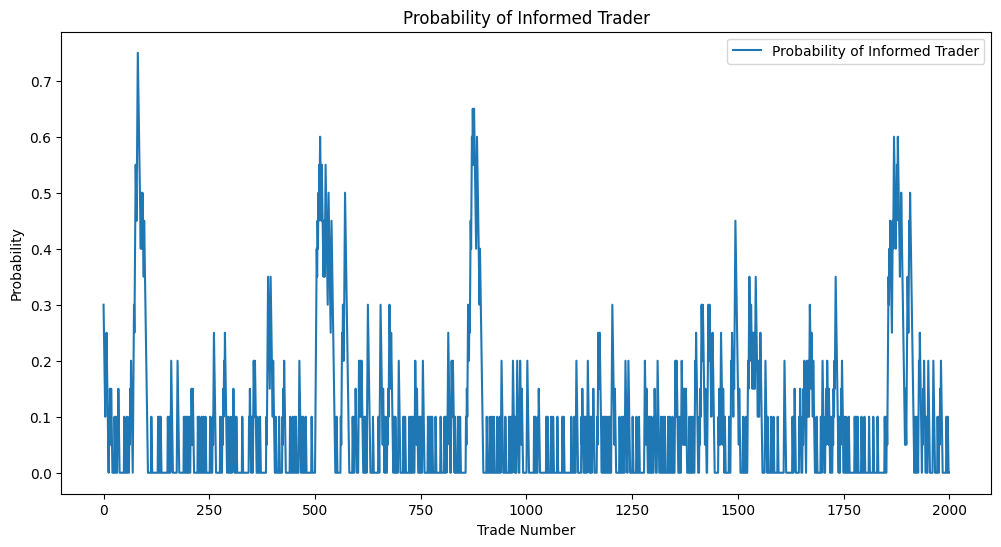

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(
    trades['probability_informed'], label='Probability of Informed Trader'
)
plt.legend()
plt.title('Probability of Informed Trader')
plt.xlabel('Trade Number')
plt.ylabel('Probability')
plt.show()